In [12]:
import tifffile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, gaussian
from scipy.ndimage import filters
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import skew

In [13]:
# Replace with the actual path to your image

In [14]:
def extract_circle_perimeter_3d(input_path, output_path):
    # Open the 3D TIFF image
    image_stack = tifffile.imread(input_path)

    # Create an empty 3D array to store the perimeter images
    perimeter_stack = np.zeros_like(image_stack)

    # Iterate through each 2D slice (stack) in the 3D image
    for i in range(image_stack.shape[0]):
        # Get the current 2D slice
        current_slice = image_stack[i, :, :]

        # Apply the perimeter extraction algorithm to the current slice
        perimeter_img = extract_circle_perimeter_2d(current_slice)

        # Store the result in the 3D array
        perimeter_stack[i, :, :] = perimeter_img

    # Save the 3D array as a 3D TIFF image
    tifffile.imwrite(output_path, perimeter_stack)

def extract_circle_perimeter_2d(img):
    # Convert the image to a binary mode (1-bit pixels, black and white)
    img_binary = (img > 0).astype(np.uint8) * 255

    # Create a blank image with the same size and mode
    perimeter_img = np.zeros_like(img_binary, dtype=np.uint8)

    # Iterate through each pixel to find the perimeter
    for x in range(1, img.shape[1] - 1):
        for y in range(1, img.shape[0] - 1):
            # If the current pixel is white
            if img_binary[y, x] == 255:
                # Check if any neighboring pixel is black
                neighbors = [
                    img_binary[y, x - 1],
                    img_binary[y, x + 1],
                    img_binary[y - 1, x],
                    img_binary[y + 1, x],
                ]

                if 0 in neighbors:
                    # Set the corresponding pixel in the perimeter image to white
                    perimeter_img[y, x] = 255

    return perimeter_img

# Specify your input and output file paths
input_image_path_3d = "L3-E-1-a.tif" # Replace with the actual path to your image
output_image_path_3d = "shell.tiff" # Replace with the actual path to your image

# Call the function for 3D TIFF image
extract_circle_perimeter_3d(input_image_path_3d, output_image_path_3d)


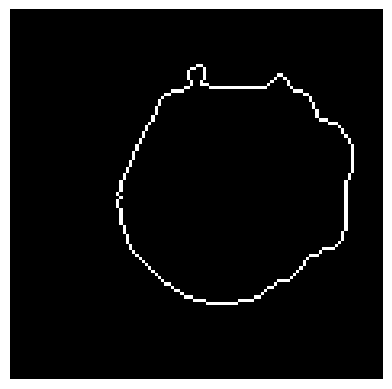

In [15]:
output_image_stack = tifffile.imread(output_image_path_3d)
plt.imshow(output_image_stack [0, :, :], cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

In [16]:
def extract_and_save_first_slice(input_path, output_path):
    # Read the 3D TIFF image
    image_stack = tifffile.imread(input_path)

    # Extract the first slice from the 3D stack
    first_slice = image_stack[0, :, :]

    # Save the first slice as a TIFF image
    tifffile.imwrite(output_path, first_slice)

# Specify the input and output file paths
input_image_path_3d = "shell.tiff" # Replace with the actual path to your image
output_image_path_2d = "shell-01.tiff" # Replace with the actual path to your image

# Call the function to extract and save the first slice
extract_and_save_first_slice(input_image_path_3d, output_image_path_2d)

Perimeter of the fitted ellipse: 224.24 pixels


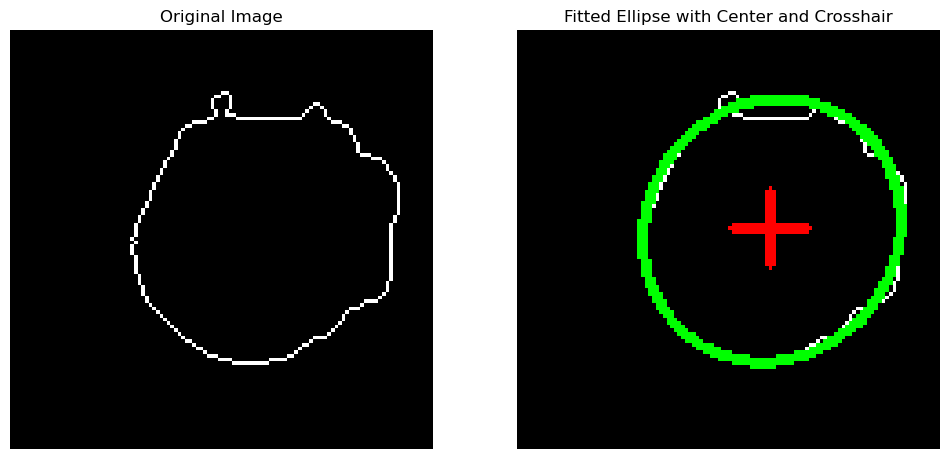

In [17]:
# Load the image
image_path = "shell-01.tiff"  # Replace with the actual path to your image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Threshold the image to create a binary mask
_, binary_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Find contours in the binary mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Fit ellipse to the largest contour (assuming the circular shape is the largest)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    ellipse = cv2.fitEllipse(largest_contour)

    # Extract center coordinates of the ellipse
    center = (int(ellipse[0][0]), int(ellipse[0][1]))
    # Extract semi-major and semi-minor axes from the fitted ellipse
    a = ellipse[1][0] / 2.0
    b = ellipse[1][1] / 2.0
    
    # Calculate the perimeter of the ellipse using Ramanujan's formula
    perimeter = np.pi * (3 * (a + b) - np.sqrt((3 * a + b) * (a + 3 * b)))

    # Print the calculated perimeter
    print(f"Perimeter of the fitted ellipse: {perimeter:.2f} pixels")

    # Draw the ellipse and its center on a copy of the original image
    image_with_ellipse = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.ellipse(image_with_ellipse, ellipse, (0, 255, 0), 2)

    # Draw a crosshair or marker at the center
    crosshair_size = 10
    cv2.line(image_with_ellipse, (center[0] - crosshair_size, center[1]), (center[0] + crosshair_size, center[1]), (0, 0, 255), 2)
    cv2.line(image_with_ellipse, (center[0], center[1] - crosshair_size), (center[0], center[1] + crosshair_size), (0, 0, 255), 2)

    # Display the original image and the image with the fitted ellipse and center side by side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Fitted Ellipse with Center and Crosshair")
    plt.imshow(cv2.cvtColor(image_with_ellipse, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()
else:
    print("No contours found in the binary image.")


In [18]:
# Calculate polar coordinates for white pixels
if contours:
    polar_coordinates = []
    for y in range(binary_mask.shape[0]):
        for x in range(binary_mask.shape[1]):
            if binary_mask[y, x] == 255:  # White pixel
                # Calculate polar coordinates
                dx = x - center[0]
                dy = y - center[1]
                radius = np.sqrt(dx**2 + dy**2)
                angle = np.arctan2(dy, dx)
                polar_coordinates.append((angle, radius))

    # Convert angles to the range [0, 2*pi]
    polar_coordinates = np.array(polar_coordinates)
    polar_coordinates[:, 0] = (polar_coordinates[:, 0] + 2 * np.pi) % (2 * np.pi)

    # Sort polar coordinates based on angle
    polar_coordinates = polar_coordinates[polar_coordinates[:, 0].argsort()]

    # Add a new column "X values" based on the corrected formula
    df = pd.DataFrame(polar_coordinates, columns=["Angle", "Radius"])
    df['X values'] = 0.0  # Initialize the column with zeros
    for i in range(2, len(df)):
        df.at[i, 'X values'] = df.at[i - 1, 'X values'] + (df.at[i, 'Angle'] - df.at[i - 2, 'Angle']) * np.average([df.at[i - 1, 'Radius'], df.at[i, 'Radius']])

    # Save polar coordinates to Excel file
    excel_filename = "polar_coordinates_with_X_values.xlsx"
    df.to_excel(excel_filename, index=False)
    print(f"Polar coordinates with corrected X values saved to {excel_filename}")
else:
    print("No contours found in the binary image.")

Polar coordinates with corrected X values saved to polar_coordinates_with_X_values.xlsx


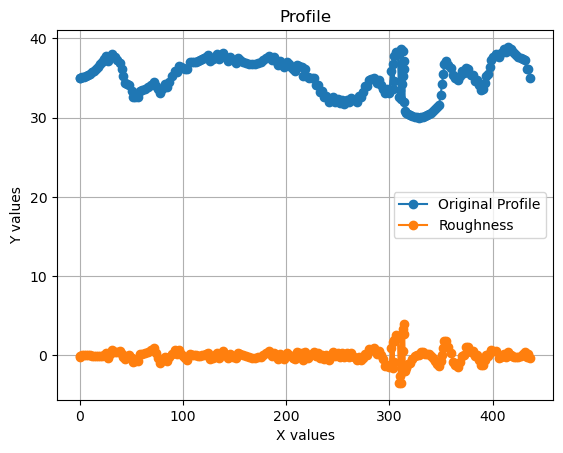

In [19]:


# Load data from Excel file
excel_file_path = "polar_coordinates_with_X_values.xlsx"
df = pd.read_excel(excel_file_path)

# Extract X and Y columns
x_values = df.iloc[:, 2]  # Assuming 'X' is the first column
y_values = df.iloc[:, 1]  # Assuming 'Y' is the second column

# Plot the original profile
plt.plot(x_values, y_values, marker='o', linestyle='-', label='Original Profile')
plt.title('Profile')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.grid(True)

# Apply Savitzky-Golay filter to smooth the profile
# window_lenght value can change the level of filteration
smoothed_profile = savgol_filter(y_values, window_length=21, polyorder=3)

# Subtract the smoothed profile to obtain roughness
roughness = y_values - smoothed_profile

# Plot the roughness
plt.plot(x_values, roughness, marker='o', linestyle='-', label='Roughness')
plt.legend()
plt.show()


In [20]:
resolution=5.74
def calculate_roughness(profile):
    ra = resolution*np.mean(np.abs(profile))  # Roughness average
    rq = resolution*np.sqrt(np.mean(profile**2))  # Root Mean Square Roughness
    rz = resolution*np.max(profile) - np.min(profile)  # Maximum Roughness Depth
    rsk = skew(profile) # Calculate skweness
    return ra, rq, rz, rsk

In [21]:
# Create empty lists to store roughness parameters for each slice index
ra_values = []
rz_values = []
rq_values = []
rsk_values = []

for i in range(output_image_stack.shape[0]):
    # Get the current 2D slice
    current_slice= output_image_stack[i, :, :]
    # Threshold the image to create a binary mask
    _, binary_mask = cv2.threshold(current_slice, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Fit ellipse to the largest contour (assuming the circular shape is the largest)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        ellipse = cv2.fitEllipse(largest_contour)

        # Extract center coordinates of the ellipse
        center = (int(ellipse[0][0]), int(ellipse[0][1]))
        # Extract semi-major and semi-minor axes from the fitted ellipse
        a = ellipse[1][0] / 2.0
        b = ellipse[1][1] / 2.0
    
        # Calculate the perimeter of the ellipse using Ramanujan's formula
        perimeter = np.pi * (3 * (a + b) - np.sqrt((3 * a + b) * (a + 3 * b)))
    else:
        print("No contours found in the binary image.")
        # Calculate polar coordinates for white pixels
    if contours:
        polar_coordinates = []
        for y in range(binary_mask.shape[0]):
            for x in range(binary_mask.shape[1]):
                if binary_mask[y, x] == 255:  # White pixel
                    # Calculate polar coordinates
                    dx = x - center[0]
                    dy = y - center[1]
                    radius = np.sqrt(dx**2 + dy**2)
                    angle = np.arctan2(dy, dx)
                    polar_coordinates.append((angle, radius))

        # Convert angles to the range [0, 2*pi]
        polar_coordinates = np.array(polar_coordinates)
        polar_coordinates[:, 0] = (polar_coordinates[:, 0] + 2 * np.pi) % (2 * np.pi)

        # Sort polar coordinates based on angle
        polar_coordinates = polar_coordinates[polar_coordinates[:, 0].argsort()]

        # Add a new column "X values" based on the corrected formula
        df = pd.DataFrame(polar_coordinates, columns=["Angle", "Radius"])
        df['X values'] = 0.0  # Initialize the column with zeros
        for i in range(2, len(df)):
            df.at[i, 'X values'] = df.at[i - 1, 'X values'] + (df.at[i, 'Angle'] - df.at[i - 2, 'Angle']) * np.average([df.at[i - 1, 'Radius'], df.at[i, 'Radius']])

        # Save polar coordinates to Excel file
        excel_filename = "polar_coordinates_with_X_values.xlsx"
        df.to_excel(excel_filename, index=False)
        
    else:
        print("No contours found in the binary image.")
        # Load data from Excel file
    excel_file_path = "polar_coordinates_with_X_values.xlsx"
    df = pd.read_excel(excel_file_path)

    # Extract X and Y columns
    x_values = df.iloc[:, 2]  # Assuming 'X' is the first column
    y_values = df.iloc[:, 1]  # Assuming 'Y' is the second column
    # Apply Savitzky-Golay filter to smooth the profile
    # window_lenght value can change the level of filteration
    smoothed_profile = savgol_filter(y_values, window_length=21, polyorder=3)
    # Subtract the smoothed profile to obtain roughness
    roughness = y_values - smoothed_profile

    # Calculate roughness parameters for the filtered profile
    ra, rq, rz, rsk = calculate_roughness(roughness)
   

    # Append roughness parameters to the lists
    ra_values.append(ra)
    rz_values.append(rz)
    rq_values.append(rq)
    rsk_values.append(rsk)

# Create a DataFrame with the results
result_df = pd.DataFrame({
    "Slice Index": range(output_image_stack.shape[0]),
    "Ra Value": ra_values,
    "Rz Value": rz_values,
    "Rq Value": rq_values,
    "Rsk Value": rsk_values})

# Save the results to an Excel file
excel_filename = r"C:\Users\AQ77330\OneDrive - ETS\PhD\Paper-confrence-thesis\Journal\Lattice\Codes\roughness.xlsx"
result_df.to_excel(excel_filename, index=False)


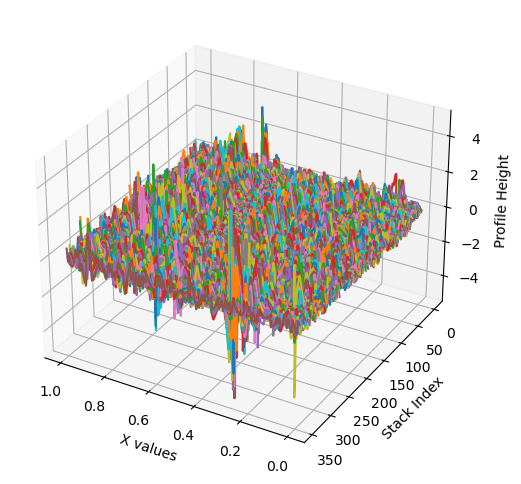

C:\Users\AQ77330\AppData\Local\Temp\ipykernel_20192\3119332134.py:130: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothed_map_smoothed = filters.gaussian_filter(roughness_map_smoothed, sigma=sigma)
C:\Users\AQ77330\AppData\Local\Temp\ipykernel_20192\3119332134.py:131: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothed_map_raw = filters.gaussian_filter(roughness_map_raw, sigma=sigma)


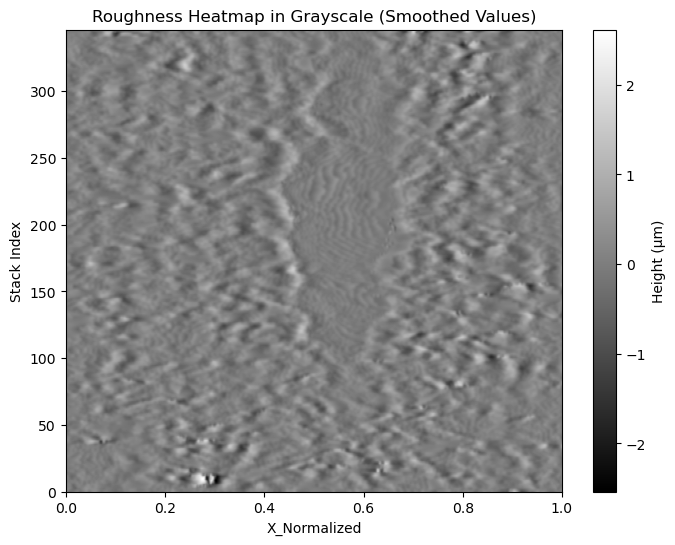

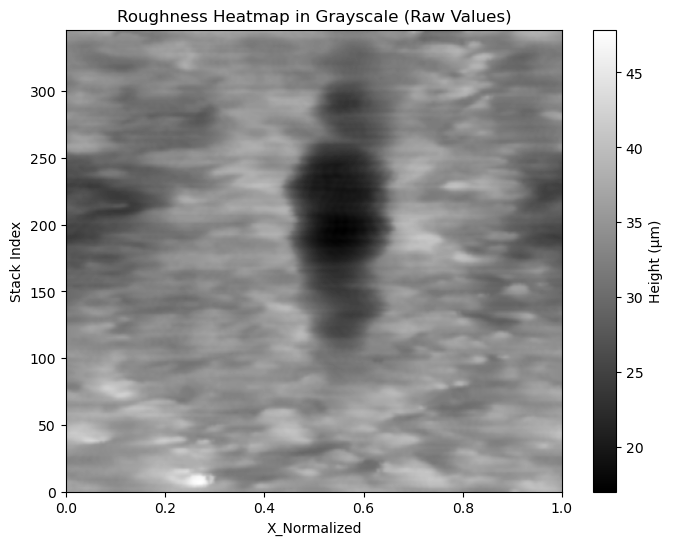

In [22]:


# Define the calculate_roughness function
def calculate_roughness(roughness):
    ra = np.mean(np.abs(roughness))
    rq = np.sqrt(np.mean(roughness**2))
    rz = np.max(roughness) - np.min(roughness)
    return ra, rq, rz

# Create empty lists to store roughness parameters for each slice index
ra_values = []
rz_values = []
rq_values = []

# Create an empty 3D plot
fig = plt.figure(figsize=(10, 6))  # Smaller figure size
ax = fig.add_subplot(111, projection='3d')

# Collect all roughness values in 2D arrays for the heatmaps
roughness_map_smoothed = []
roughness_map_raw = []

# Define a common set of X values for normalization
common_x_values = np.linspace(0, 1, 500)  # Decreased to 500 for smaller images

for i in range(output_image_stack.shape[0]):
    try:
        # Get the current 2D slice
        current_slice = output_image_stack[i, :, :]
        
        # Threshold the image to create a binary mask
        _, binary_mask = cv2.threshold(current_slice, 127, 255, cv2.THRESH_BINARY)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            ellipse = cv2.fitEllipse(largest_contour)

            # Extract center coordinates of the ellipse
            center = (int(ellipse[0][0]), int(ellipse[0][1]))
            # Extract semi-major and semi-minor axes from the fitted ellipse
            a = ellipse[1][0] / 2.0
            b = ellipse[1][1] / 2.0
        
            # Calculate the perimeter of the ellipse using Ramanujan's formula
            perimeter = np.pi * (3 * (a + b) - np.sqrt((3 * a + b) * (a + 3 * b)))

            # Calculate polar coordinates for white pixels
            polar_coordinates = []
            for y in range(binary_mask.shape[0]):
                for x in range(binary_mask.shape[1]):
                    if binary_mask[y, x] == 255:  # White pixel
                        # Calculate polar coordinates
                        dx = x - center[0]
                        dy = y - center[1]
                        radius = np.sqrt(dx**2 + dy**2)
                        angle = np.arctan2(dy, dx)
                        polar_coordinates.append((angle, radius))

            # Convert angles to the range [0, 2*pi]
            polar_coordinates = np.array(polar_coordinates)
            polar_coordinates[:, 0] = (polar_coordinates[:, 0] + 2 * np.pi) % (2 * np.pi)

            # Sort polar coordinates based on angle
            polar_coordinates = polar_coordinates[polar_coordinates[:, 0].argsort()]

            # Add a new column "X values" based on the corrected formula
            df = pd.DataFrame(polar_coordinates, columns=["Angle", "Radius"])
            df['X values'] = 0.0  # Initialize the column with zeros
            for j in range(2, len(df)):
                df.at[j, 'X values'] = df.at[j - 1, 'X values'] + (df.at[j, 'Angle'] - df.at[j - 2, 'Angle']) * np.average([df.at[j - 1, 'Radius'], df.at[j, 'Radius']])

            # Normalize the X values to range [0, 1]
            df['X values'] = (df['X values'] - df['X values'].min()) / (df['X values'].max() - df['X values'].min())

            # Apply Savitzky-Golay filter to smooth the profile
            smoothed_profile = savgol_filter(df['Radius'], window_length=21, polyorder=3)
        
            # Subtract the smoothed profile to obtain roughness
            roughness_smoothed = df['Radius'] - smoothed_profile

            # Interpolate roughness to the common X values for smoothed and raw values
            interp_func_smoothed = interp1d(df['X values'], roughness_smoothed, bounds_error=False, fill_value=np.nan)
            interp_func_raw = interp1d(df['X values'], df['Radius'], bounds_error=False, fill_value=np.nan)
            
            roughness_interp_smoothed = interp_func_smoothed(common_x_values)
            roughness_interp_raw = interp_func_raw(common_x_values)

            # Append interpolated roughness to the roughness maps
            roughness_map_smoothed.append(roughness_interp_smoothed)
            roughness_map_raw.append(roughness_interp_raw)

            # Calculate roughness parameters for the filtered profile
            ra, rq, rz = calculate_roughness(roughness_smoothed)

            # Append roughness parameters to the lists
            ra_values.append(ra)
            rz_values.append(rz)
            rq_values.append(rq)

            # Draw roughness values versus common_x_values for each iteration
            ax.plot(common_x_values, roughness_interp_smoothed, zs=i, zdir='y', label=f'Slice {i}')
            
        else:
            print(f"No contours found in the binary image for slice {i}.")
            continue
    except Exception as e:
        print(f"Error processing slice {i}: {e}")
        continue

# Set labels for the plot
ax.set_xlabel('X values')
ax.set_ylabel('Stack Index')
ax.set_zlabel('Profile Height')

# Adjust the viewing angle and perspective for better visualization
ax.view_init(elev=30, azim=120)

plt.show()

try:
    # Convert roughness maps to properly shaped numpy arrays for heatmaps
    roughness_map_smoothed = np.vstack(roughness_map_smoothed)
    roughness_map_raw = np.vstack(roughness_map_raw)
except Exception as e:
    print(f"Error during vstack: {e}")

# Apply Gaussian smoothing to the heatmaps
sigma = 1  # Adjust sigma for more or less smoothing
smoothed_map_smoothed = filters.gaussian_filter(roughness_map_smoothed, sigma=sigma)
smoothed_map_raw = filters.gaussian_filter(roughness_map_raw, sigma=sigma)

# Plot the heatmap for smoothed values
try:
    plt.figure(figsize=(8, 6))  # Smaller figure size
    plt.imshow(smoothed_map_smoothed, cmap='gray', aspect='auto', extent=[0, 1, 0, len(smoothed_map_smoothed)])
    plt.colorbar(label='Height (\u03BCm)')
    plt.xlabel('X_Normalized')
    plt.ylabel('Stack Index')
    plt.title('Roughness Heatmap in Grayscale (Smoothed Values)')
    plt.show()
except Exception as e:
    print(f"Error plotting smoothed heatmap: {e}")

# Plot the heatmap for raw values
try:
    plt.figure(figsize=(8, 6))  # Smaller figure size
    plt.imshow(smoothed_map_raw, cmap='gray', aspect='auto', extent=[0, 1, 0, len(smoothed_map_raw)])
    plt.colorbar(label='Height (\u03BCm)')
    plt.xlabel('X_Normalized')
    plt.ylabel('Stack Index')
    plt.title('Roughness Heatmap in Grayscale (Raw Values)')
    plt.show()
except Exception as e:
    print(f"Error plotting raw heatmap: {e}")
